<a href="https://colab.research.google.com/github/Abhisikta11/Emotion_Detection1/blob/main/Emotion_Detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Uploading dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q "/content/drive/MyDrive/1Emotion_Detection/animal_emotion.zip"

**Importing libraries**

In [4]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import shutil
from sklearn.model_selection import train_test_split

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.15.0


**Spliting the dataset**

In [5]:
dataset_path = '/content/Animal Emotion'
train_dir = '/content/Animal Emotion/train'
val_dir = '/content/Animal Emotion/validation'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)

!pip install scikit-learn

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path) and category not in ['train', 'validation']:
        images = glob(os.path.join(category_path, '*.jpg'))
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        os.makedirs(train_category_dir)
        os.makedirs(val_category_dir)

        for img in train_images:
            shutil.copy(img, train_category_dir)
        for img in val_images:
            shutil.copy(img, val_category_dir)

print("Data split into training and validation sets.")

Data split into training and validation sets.


**Exploring Dataset**

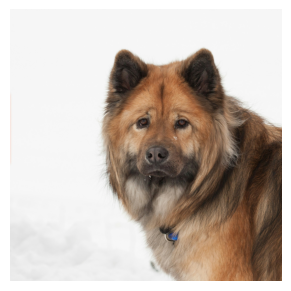

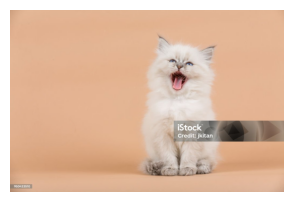

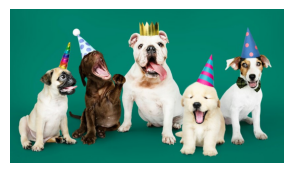

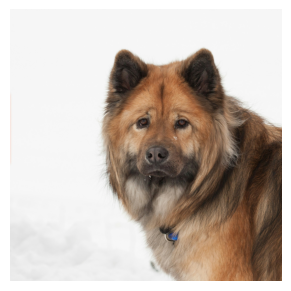

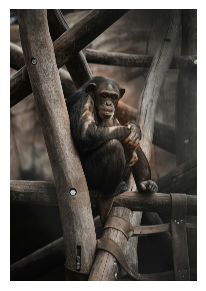

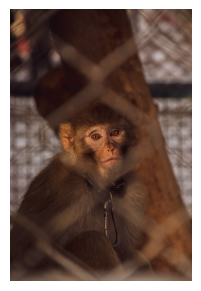

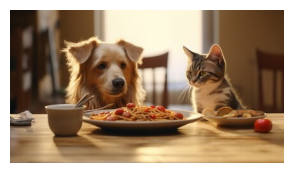

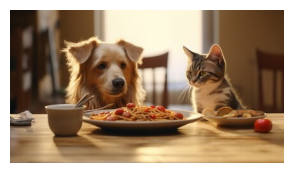

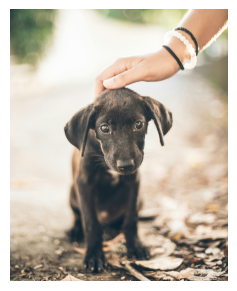

In [6]:
from glob import glob
import random
import matplotlib.pyplot as plt
import os
import cv2
train_img = os.path.join(train_dir, '**', '*.jpg')
images = glob(train_img)
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB));
    plt.axis('off')
plt.show()

**Preparing Data for Training**

In [7]:
img_size = 48
batch_size = 6
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train. flow_from_directory("/content/Animal Emotion/train",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

validation_generator = datagen_train.flow_from_directory("/content/Animal Emotion/validation",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 54 images belonging to 3 classes.
Found 14 images belonging to 3 classes.


**Defining model**

In [8]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [9]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [10]:
def model_fer(input_shape, num_classes):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,256,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)

    output  = Dense(num_classes, activation="softmax")(dense_2)
    model  =  Model(inputs=[inputs],outputs = [output])

    opt = Adam(learning_rate=0.0005)

    model.compile(loss='categorical_crossentropy' , optimizer = opt , metrics =['accuracy'])

    return model

In [ ]:
num_classes = 3
model = model_fer((48,48,1), num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

**Intializing the model**

In [ ]:
epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor =0.1, patience = 2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stop]

In [ ]:
print("Number of samples in train_generator:", train_generator.n)


Number of samples in train_generator: 54


**Training the model**

In [ ]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.4767 - accuracy: 0.4074
Epoch 1: saving model to model.weights.h5
9/9 [==============================] - 30s 2s/step - loss: 1.4767 - accuracy: 0.4074 - val_loss: 1.0932 - val_accuracy: 0.4167 - lr: 5.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.3057 - accuracy: 0.4074
Epoch 2: saving model to model.weights.h5
9/9 [==============================] - 20s 2s/step - loss: 1.3057 - accuracy: 0.4074 - val_loss: 1.0944 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3429 - accuracy: 0.3519
Epoch 3: saving model to model.weights.h5
9/9 [==============================] - 18s 2s/step - loss: 1.3429 - accuracy: 0.3519 - val_loss: 1.1186 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.9873 - accuracy: 0.5926
Epoch 4: saving model to model.weights.h5
9/9 [===========================

**Model Evaluation**

In [ ]:
model.evaluate(validation_generator)

3/3 [==============================] - 5s 2s/step - loss: 1.0918 - accuracy: 0.4286


[1.0918368101119995, 0.4285714328289032]

**Plotting loss**

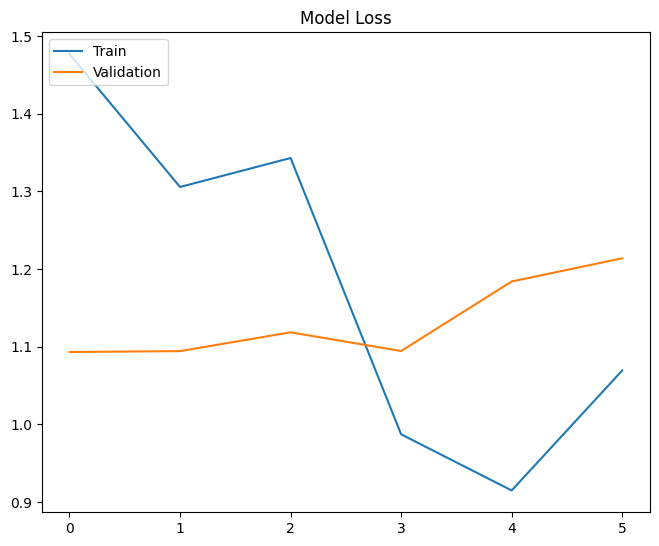

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

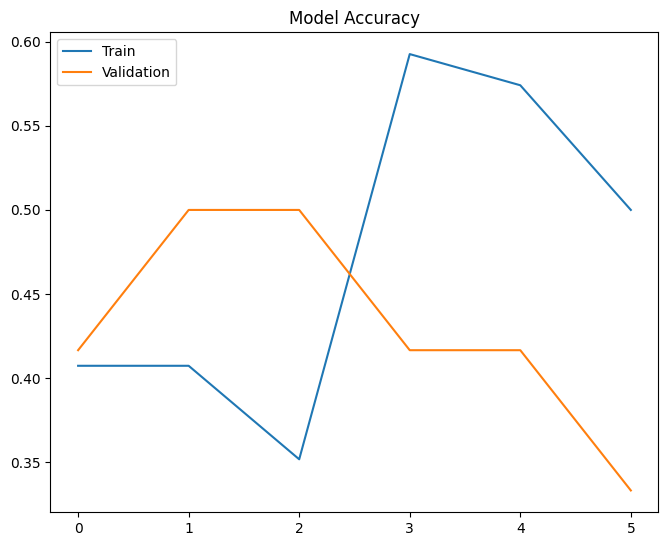

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [ ]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)

**Uploading files**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gui.py to gui.py
Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml
Saving model_a.json to model_a (1).json


In [ ]:
!ls

'Animal Emotion'   gui.py				'model_a (1).json'   model.weights.h5
 drive		   haarcascade_frontalface_default.xml	 model_a.json	     sample_data


In [ ]:
import os
import tkinter as tk
from tkinter import filedialog, Label, Button
from tkinter import *

from sklearn import metrics

from tensorflow.keras.models import model_from_json
from PIL import Image, ImageTk
import numpy as numpy
import cv2

def FacialExpressionModel(json_file, weights_file):
  loaded_model_json = None
  with open(json_file,"r") as file:
        loaded_model_json = file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights(weights_file)
        model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

        return model

!apt-get install -y xvfb
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()

json_file = "model_a.json"
weights_file = "model.weights.h5"
weights_path = os.path.abspath(weights_file)
model = FacialExpressionModel(json_file, weights_path)

top= tk.Tk()
top.geometry('800x600')
top.title('Animal Emotion Detector')
top.configure(background='#CDCDCD')

label1 = Label(top, background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model_a.json", "model.weights.h5")


EMOTIONS_LIST = ["Happy","Sad","Hungry"]
ANIMALS_LIST = ["Dog", "Cat", "Cow", "Giraffe", "Elephant", "Lion", "Pigeon", "Dolphin", "Duck", "Mouse", "Goat", "Parrot", "Monkey"]

def Detect(file_path):
    global Label_packed

    image = cv2.imread(file_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray_image,1.3,5)
    try:
        for (x,y,w,h) in faces:
            fc = gray_image[y:y+h,x:x+w]
            roi = cv2.resize(fc,(48,48))
            roi = roi.astype('float') / 255.0
            roi = np.asarray(roi)
            roi = np.expand_dims(roi, axis=0)
            roi = np.expand_dims(roi, axis=-1)
            pred_emotion = EMOTIONS_LIST[np.argmax(model.predict(roi[np.newaxis,:,:,np.newaxis]))]
            pred_animal = ANIMALS_LIST[np.argmax(model.predict(roi[np.newaxis,:,:,np.newaxis]))]
        results.append(f"{pred_animal}: {pred_emotion}")
        label1.configure(foreground="#011638",text = pred)
    except:
        label1.configure(foreground="#011638",text = "Unable to detect")

def show_Detect_button(file_path):
    detect_b = Button(top,text="Detect Emotion", command= lambda: Detect(file_path),padx=10,pady=5)
    detect_b.configure(background="#364156",foreground='white',font=('arial',10,'bold'))
    detect_b.place(relx =0.79,rely=0.46)
    pass


def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.3),(top.winfo_height()/2.3)))
        im = ImageTk.PhotoImage(uploaded)

        sign_image.configure(image = im)
        sign_image.image = im
        label1.configure(text = '')
        show_Detect_button(file_path)
    except:
        pass

upload = Button(top,text = "Upload Image", command = upload_image,padx=10,pady=5)
upload.configure(background="#364156",foreground='white',font=('arial',20,'bold'))
upload.pack(side='bottom',pady=50)
sign_image.pack(side='bottom',expand='True')
label1.pack(side='bottom',expand='True')
heading = Label(top,text='Emotion Detector',pady=20,font=('arial',25,'bold'))
heading.configure(background='#CDCDCD',foreground="#364156")
heading.pack()

top.mainloop()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv